<h1> Scrape Data -> preprocess/clean -> scale -> regression </h1>
<h3>by Angelo Cortez (UC Irvine)  Lee Sangbec (UC Berkeley) </h3>

In [32]:
# Import our needed modules
# numpy and pandas to manipulate the csv's dataframe components
import numpy as np
import pandas as pd

In [33]:
tyo=pd.read_csv('listings.csv')

In [34]:
tyo.dropna(axis=0, how='all', inplace=True)

In [35]:
# Then we import our listings file. We do not want to see blank rows, so we shall delete them with the .dropna method
# We want to see if there are any duplicates in the dataframe. We can achieve this by comparing listing ID's.
# By using the lambda method below, we can extract the id in the URL, then by applying the .drop_duplciates() method,
# we can find delete those with duplicate url's. 

tyo.url = tyo.url.apply(lambda x:str(x).split('?')[0])
tyo = tyo.drop_duplicates(subset=['url'])

In [36]:
# We want to reconstruct the Entire_home/apt feature and the book_instantly with dummy variables. 
# This is achievable by using the .map function.

tyo['Entire_home/apt'] = tyo.room_type.map({'Entire home/apt':1, 'Private room': 0, 'Shared room': 0})
tyo['book_instantly'] = tyo.instant_book.map({True:1, False: 0 })
tyo.drop('instant_book', axis=1, inplace = True)

# We don't need the url feature. 
tyo.drop('url', axis=1, inplace=True)

In [37]:
# We can also take care of dummies using for loops!

booleans=[]
for i in tyo.bed_type:
    if i == 'Real Bed':
        booleans.append(1)
    else:
        booleans.append(0)
tyo['bed_type'] = booleans


In [38]:
# Dropping the cancel policy sice it is uninteresting. 

tyo.drop('cancel_policy',axis=1, inplace=True)   

In [39]:
tyo.drop(0, axis=0, inplace=True)
tyo.drop('room_type', axis=1, inplace = True)
X = tyo.drop(['price','amenities','response_time'], axis=1)
y = tyo.price
# Set X and Y variables here. 


In [40]:
X.isnull().sum().sort_values(ascending=False).head() 


satisfaction_guest      28
rating_communication    28
rating_cleanliness      28
rating_checkin          28
accuracy                28
dtype: int64

In [41]:
def show_best(grid_pipe):
    print(f'Best params: {grid_pipe.best_params_} \nBest score: {-1*grid_pipe.best_score_}')

In [42]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)


In [43]:
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

In [44]:

pipeline3 = Pipeline([
    ('imp', Imputer(missing_values='NaN', strategy = 'mean', axis=0)),
    ('rgr', GradientBoostingRegressor())
])

tuned_parameters = {
    "rgr__n_estimators":      [ n for n in range(80,200,10)],
    "rgr__max_depth" :        [ 3  ],
    "rgr__learning_rate":     [   0.1],
    "rgr__min_samples_split" :[ 4,    6    , 8],
    "rgr__loss" :             [ 'ls', 'lad'                  ],
    "rgr__max_features":      [ 1.0, 0.8,  0.5, 0.3   , 0.1    ]}

noScalePipe = GridSearchCV(pipeline3, tuned_parameters, cv=5, scoring='neg_median_absolute_error')
noScalePipe.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('rgr', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_de...s=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'rgr__n_estimators': [80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190], 'rgr__max_depth': [3], 'rgr__learning_rate': [0.1], 'rgr__min_samples_split': [4, 6, 8], 'rgr__loss': ['ls', 'lad'], 'rgr__max_features': [1.0, 0.8, 0.5, 0.3, 0.1]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_median_absolute_error', verbose=0)

In [45]:
show_best(noScalePipe)

Best params: {'rgr__learning_rate': 0.1, 'rgr__loss': 'lad', 'rgr__max_depth': 3, 'rgr__max_features': 0.5, 'rgr__min_samples_split': 4, 'rgr__n_estimators': 130} 
Best score: 13.865838570478287


In [73]:
x = noScalePipe.fit(X_train, y_train)


Now we instantiate the GBRegressor into a new pipeline so we can extract feature importances from it (scikit-learn deos not allow us to extract feature importances from a gridsearched pipeline). 

In [86]:
gbt = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='lad', max_depth=3, max_features=0.8,
               max_leaf_nodes=None, min_impurity_decrease=0.0,
               min_impurity_split=None, min_samples_leaf=1,
               min_samples_split=6, min_weight_fraction_leaf=0.0,
               n_estimators=180, presort='auto', random_state=None,
               subsample=1.0, verbose=0, warm_start=False)
pipeline = Pipeline([
    ('imp', Imputer(missing_values='NaN', strategy = 'mean', axis=0)),
    ('rgr', gbt)
])
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('rgr', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=3, max_features=0.8,
             max_leaf_nodes=None, min_impurity_de...s=180, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False))])

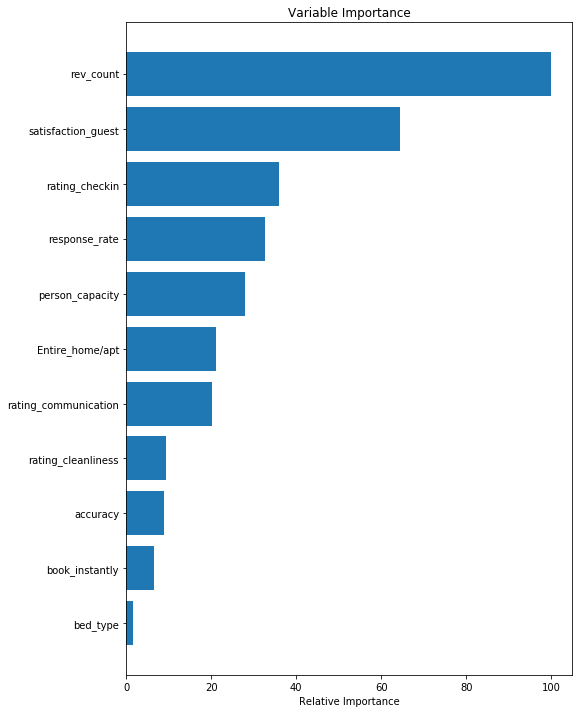

In [87]:
feature_importance = gbt.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

#As expected, person capacity was the most important variable when predicting price

We can see that the median absolute error was around $13 with the GBRegressor. Now let's compare it to other statistical models below. 

In [17]:
imp = Imputer(missing_values='NaN', strategy = 'mean', axis=0)
imp.fit(X)
X = pd.DataFrame(data=imp.transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

[ 21.82790829  21.79494255  21.94992209  22.29651961  21.12379855
  23.7814173 ]


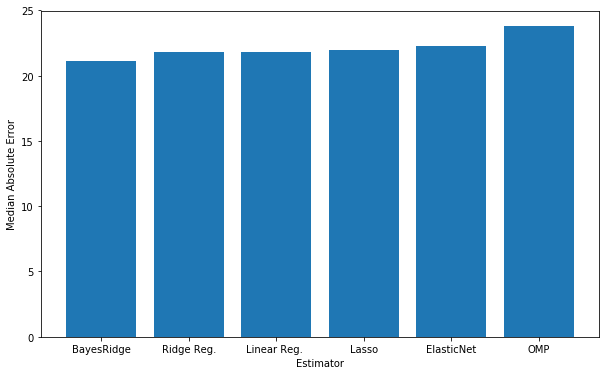

In [18]:
# get median error values using sklearn. 
# use matplotlib to graph the calculations
from sklearn import linear_model
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn import ensemble


%matplotlib inline

rs = 1

ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear Reg. ', 'Ridge Reg.', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])

for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    #print "got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)

    
pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(10,6))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')
print(errvals)

# calculate median error using gradient boosting regression


<li> We can see that other untuned statistical estimators give us a median absolute error rate of around 21 to 23 dollars. At an error of about 13 dollars, we can conclude that GBRegressor serves as a more accurate estimator.  </li>

(array([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
          9.5,  10.5]), <a list of 11 Text xticklabel objects>)

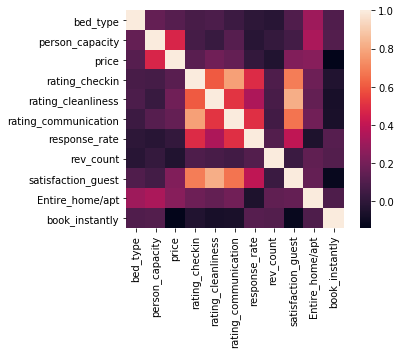

In [88]:
# Below we can see the Pearson's r correlation of the listings data. 
# Pearson's r measures the strength of the linear relationship between two variables. 
# We can see that the most correlated to price is the person capacity of a listing. 

pears= X = tyo.drop(['amenities','response_time'], axis=1)
import seaborn as sns
%matplotlib inline
corr_matrix = pears.corr()
sns.heatmap(corr_matrix, square=True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)

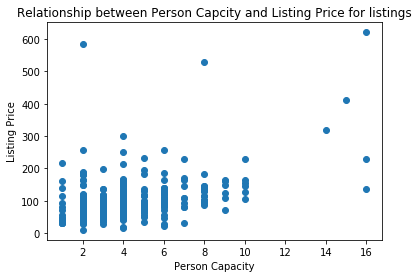

In [18]:
plt.scatter(tyo.person_capacity,tyo.price)
plt.xlabel("Person Capacity")
plt.ylabel("Listing Price")
plt.title("Relationship between Person Capacity and Listing Price for listings")
plt.show()